In [1]:
import os
import sys
import pickle
import numpy as np

# sys.path.append('/n/home04/aboesky/berger/Weird_Galaxies')
sys.path.append('/Users/adamboesky/Research/ay98/Weird_Galaxies')

import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rc('text', usetex=True)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed

# Get best model

In [2]:
grid_results = []
for fname in os.listdir('/Users/adamboesky/Research/ay98/Weird_Galaxies/domain_transfer_grid_search/results'):
    with open(f'/Users/adamboesky/Research/ay98/Weird_Galaxies/domain_transfer_grid_search/results/{fname}', 'rb') as f:
        grid_results.append(pickle.load(f))

In [3]:
# Get the best loss
best_loss = {'test': np.inf, 'train': np.inf}
best_params = None
for params, loss in grid_results:
    if np.min(loss['test']) < np.min(best_loss['test']):
        best_params = params
        best_loss = loss

print(f'The best parameter combination in our grid search are:\n\nbatch_size, nodes_per_layer, num_linear_output_layers, learning_rate\n{best_params[::-1]}')

The best parameter combination in our grid search are:

batch_size, nodes_per_layer, num_linear_output_layers, learning_rate
[4096, [7, 9, 11, 13], 1, 0.001]


# Plots

## Loss v. Epoch

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_22054/3766946969.py:5: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.yscale('log')


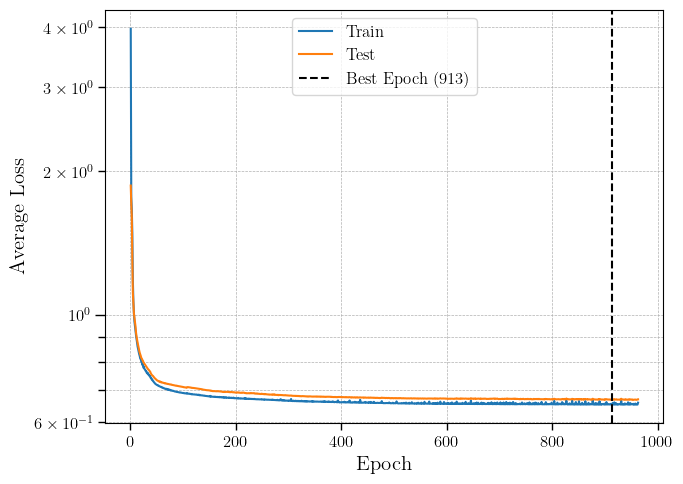

In [4]:
from matplotlib.ticker import LogLocator

plt.figure(figsize=(7, 5))
epochs = np.arange(1, len(best_loss['train']) + 1, 1)
plt.yscale('log')
plt.plot(epochs, best_loss['train'], label='Train')
plt.plot(epochs, best_loss['test'], label='Test')

# Make ticks bigger
plt.tick_params(axis='y', which='major', length=7, width=1)  # Adjust major tick size
plt.tick_params(axis='x', which='major', length=5, width=1)  # Adjust major tick size
plt.tick_params(axis='y', which='minor', length=5, width=1)  # Adjust minor tick size
best_epoch = np.argmin(best_loss['test']) + 1
plt.axvline(x=best_epoch, linestyle='--', color='k', label=f'Best Epoch ({best_epoch})')
plt.grid(True, which="both", ls="--", lw=0.5)

plt.ylabel('Average Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/domain_transfer_best_loss_v_epoch.pdf')
plt.show()

In [5]:
arg_test_min = np.argmin(best_loss['test'])
print(f'Minimum loss values:\n\ttest={best_loss["test"][arg_test_min]}\n\ttrain={best_loss["train"][arg_test_min]}')

Minimum loss values:
	test=0.6656850354276522
	train=0.6533127823093727


## Real v. Pred

In [2]:
sys.path.append('/Users/adamboesky/Research/ay98/Weird_Galaxies/Paper')
import torch
import seaborn as sns
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve
from neural_net import resume, CustomLoss, get_model, normalize_arr
from host_prop_nn import load_and_preprocess
PATH_TO_CLEAN_DATA = '/Users/adamboesky/Research/ay98/clean_data'

In [7]:
best_params

[0.001, 1, [7, 9, 11, 13], 4096]

In [8]:
# Get best model based on grid search
n_epochs = 1000
nodes_per_layer = best_params[2]
num_linear_output_layers = best_params[1]
learning_rate = best_params[0]
batch_size = best_params[3]
torch.set_default_dtype(torch.float64)
model = get_model(num_inputs=5, num_outputs=13, nodes_per_layer=nodes_per_layer, num_linear_output_layers=num_linear_output_layers)
loss_fn = CustomLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
resume(model, '/Users/adamboesky/Research/ay98/Weird_Galaxies/best_sed_model.pkl')
model.eval()

Sequential(
  (input): Linear(in_features=5, out_features=7, bias=True)
  (act_input): ReLU()
  (layer_0): Linear(in_features=7, out_features=9, bias=True)
  (act_0): ReLU()
  (layer_1): Linear(in_features=9, out_features=11, bias=True)
  (act_1): ReLU()
  (layer_2): Linear(in_features=11, out_features=13, bias=True)
  (act_2): ReLU()
  (output): Linear(in_features=13, out_features=13, bias=True)
)

In [3]:
from sed_nn import load_and_preprocess
all_photo, photo_X_train, photo_y_train, photo_Xerr_train, \
            photo_yerr_train, photo_X_test, photo_y_test, photo_Xerr_test, \
            photo_yerr_test, photo_mean, photo_std, photo_err_norm = load_and_preprocess()

2024-09-04 20:14:06,964 - sed_nn.py - INFO - Importing photometry data
2024-09-04 20:14:10,293 - sed_nn.py - INFO - Fixing the error for 96514 objects
2024-09-04 20:14:10,314 - sed_nn.py - INFO - Importing photometry data
2024-09-04 20:14:12,160 - sed_nn.py - INFO - Photo stats:
 	mean = [-2.88750664 -2.80485236 -2.79177703 -2.64890962 -2.69422682 -1.33202668
  0.06717019  0.67723176  1.35547094  0.92884049  1.34127727  1.21686633
  1.33390055 -2.42786271 -2.2128036  -1.99193711 -3.04366902 -3.0434582 ]
 	std = [0.6256189  0.69351311 0.67564669 0.71696901 0.78423232 0.88506622
 1.62868632 2.06807325 0.43284611 1.35729201 0.49397298 0.43336611
 0.45556757 2.21415807 2.12945886 2.02186998 0.66726908 0.69343955]
2024-09-04 20:14:12,161 - sed_nn.py - INFO - Catalog stats:
 	mean = [[ 8.69840122 -0.65829206  0.56184221]]
 	std = [[1.31209275 1.35189867 0.29137484]]
2024-09-04 20:14:12,163 - sed_nn.py - INFO - Length = 1261630


HEEERRRREE [[ 0.70927392  1.25512957  0.2270539 ]
 [-0.33256743  0.67634887  0.87570289]
 [-0.2748967   0.76784266  0.57368643]
 ...
 [ 0.60130756 -0.66104664  0.7521507 ]
 [-1.06907597 -0.30847975 -0.19851475]
 [-0.32610561 -0.29959755 -0.82657171]]
[[ 8.69840122 -0.65829206  0.56184221]]


2024-09-04 20:14:13,126 - sed_nn.py - INFO - Splitting into:
	X = ['G', 'R', 'I', 'Z', 'Y']
	y = ['J', 'H', 'Ks', 'CH1', 'CH2', 'MIPS24', 'MIPS70', 'PACS100', 'MIPS160', 'PACS160', 'SPIRE250', 'SPIRE350', 'SPIRE500']


In [10]:
# Predict attributes for the galaxies that have SNe
model.eval()
photo_pred: torch.Tensor = model(torch.from_numpy(photo_X_test))
photo_pred_untrans = photo_pred.detach().numpy()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_22054/3154061873.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(2, 13, figsize=(60, 10))  # Adjust figsize as needed
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_22054/3154061873.py:15: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, extent=extent, origin='lower', aspect='auto', cmap='Blues')
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_22054/3154061873.py:36: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.37])  # Adjust the position and size as needed
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_22054/3154061873.py:37: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, cax=cbar_ax, f

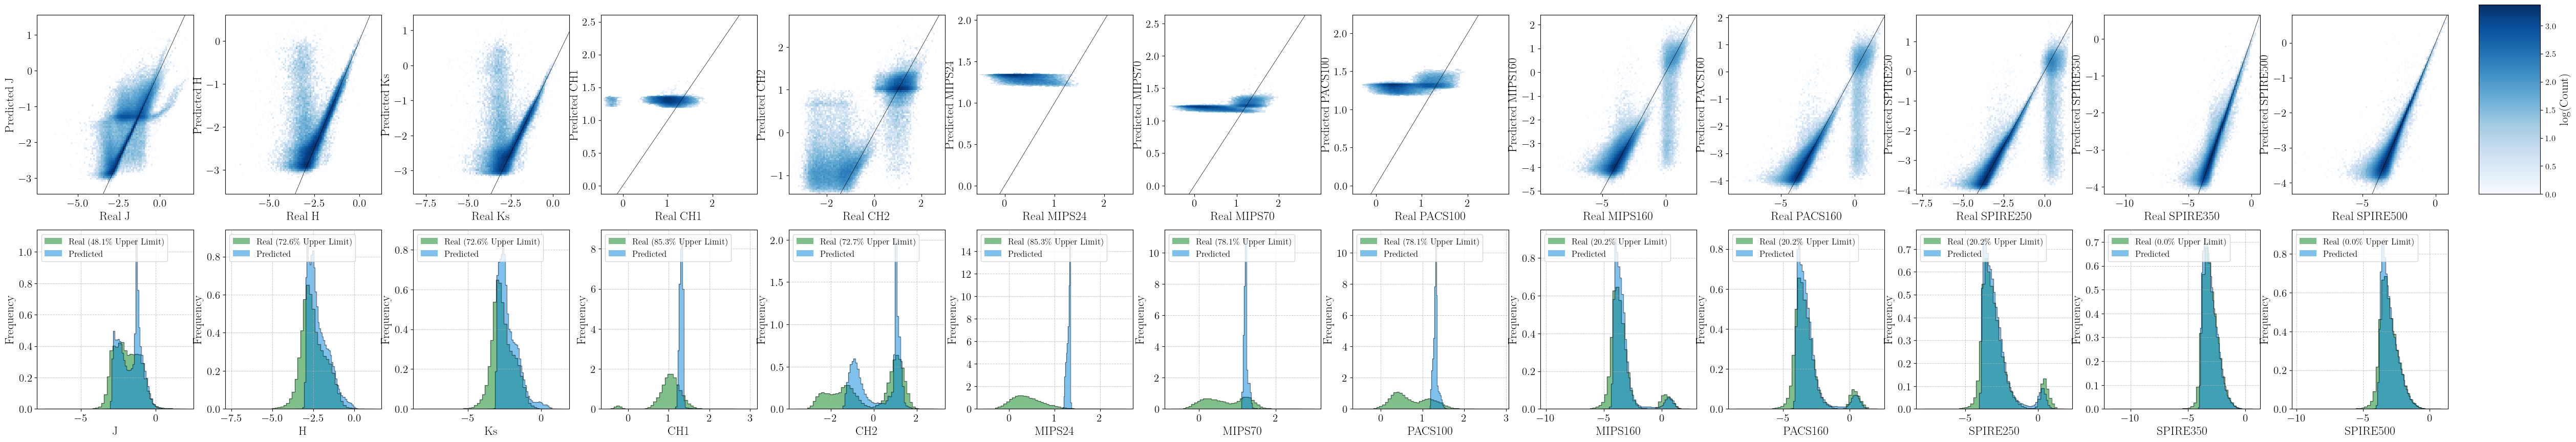

In [11]:
# Real v pred heatmaps
fig, axes = plt.subplots(2, 13, figsize=(60, 10))  # Adjust figsize as needed
pred = photo_pred_untrans * photo_std[5:] + photo_mean[5:]
real = photo_y_test * photo_std[5:] + photo_mean[5:]
params = ['J', 'H', 'Ks', 'CH1', 'CH2', 'MIPS24', 'MIPS70', 'PACS100', 'MIPS160', 'PACS160', 'SPIRE250', 'SPIRE350', 'SPIRE500']
xlims = [None for _ in range(len(params))]   # [(3, 12.1), (-8, 2.6), (0, 1), (0, 1)]
ylims = [None for _ in range(len(params))]  # [(6, 12.1), (-4.5, 1.75), (-0.05, 1), (-0.05, 1)]
up_lim_mask = (photo_y_test == 0.01)  # mask for non-upper limit vals
masks = [~up_lim_mask[:, i] for i in range(up_lim_mask.shape[1])]
pct_up_lim = (np.sum(up_lim_mask, axis=0) / up_lim_mask.shape[0]) * 100  # percentage of each band that's upper limit

for i, (param, xlim, ylim, ax, mask) in enumerate(zip(params, xlims, ylims, axes[0], masks)):
    heatmap, xedges, yedges = np.histogram2d(real[:, i][mask], pred[:, i][mask], bins=(100, 100))#, range=[xlim, ylim])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax.imshow(np.log10(heatmap).T, extent=extent, origin='lower', aspect='auto', cmap='Blues')
    ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
    # ax.set_xlim(xlim)
    # ax.set_ylim(ylim)
    ax.set_xlabel(fr'Real {param}', fontsize=17)
    ax.set_ylabel(fr'Predicted {param}', fontsize=17)
    ax.tick_params(axis='both', which='major', labelsize=15)

for i, (param, ax, lim, mask) in enumerate(zip(params, axes[1], xlims, masks)):
    ax.hist(real[:, i][mask], label=f'Real ({pct_up_lim[i].round(1)}\% Upper Limit)', alpha=0.5, density=True, bins=50, color='#008114')
    ax.hist(real[:, i][mask], alpha=0.5, density=True, bins=50, color='k', histtype='step')
    ax.hist(pred[:, i][mask], label='Predicted', alpha=0.5, density=True, bins=50, color='#0084DD')
    ax.hist(pred[:, i][mask], alpha=0.5, density=True, bins=50, color='k', histtype='step')
    ax.set_xlabel(param, fontsize=17)
    ax.set_ylabel(r'Frequency', fontsize=17)
    ax.legend(loc='upper left')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7, zorder=-1)
    # ax.set_xlim(lim)

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.37])  # Adjust the position and size as needed
cbar = fig.colorbar(im, cax=cbar_ax, fraction=1.5)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=17)  # Adjust fontsize as needed
plt.subplots_adjust(right=0.91)
plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/sed_real_v_preds.pdf', bbox_inches='tight')
plt.show()

# Fractional Error

In [4]:
# Get the median fractional error
frac_errs = []
errs = []
for i, (r, p) in enumerate(zip(real.T, pred.T)):
    # frac_errs.append(np.abs((r - p) / r))
    frac_errs.append(np.abs((r - p) / np.max((r, p))))
    errs.append(np.abs((r - p)))

errs = np.array(errs)
frac_errs = np.array(frac_errs)

NameError: name 'real' is not defined

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_22054/1395999444.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(errs[i], bins=50)


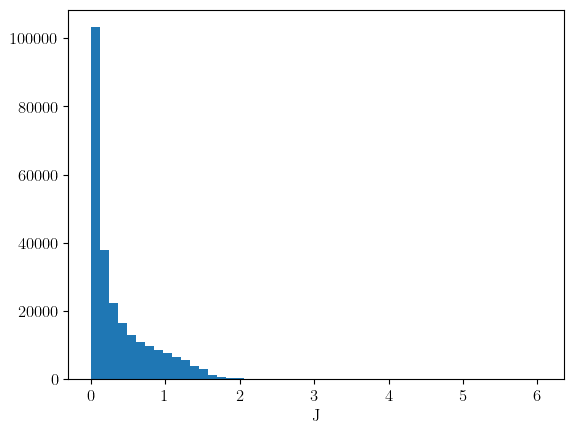

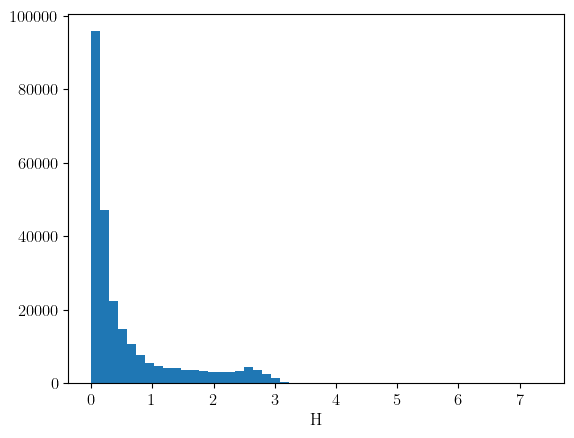

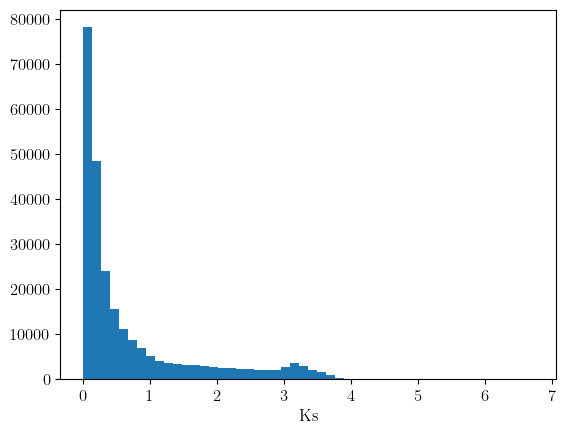

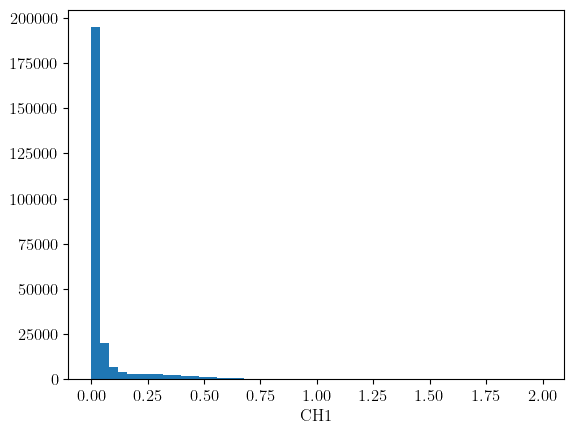

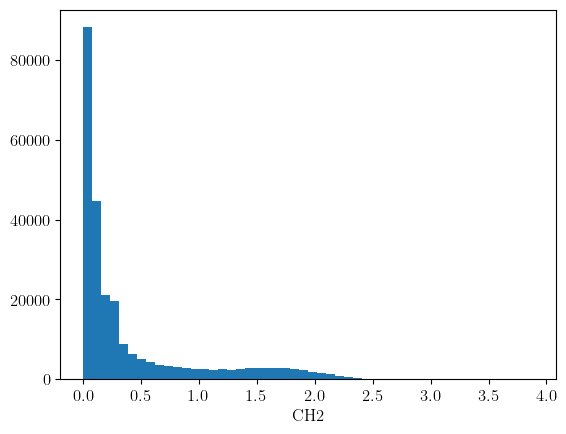

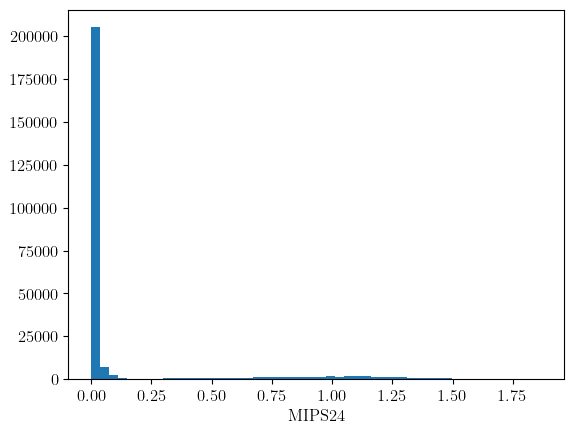

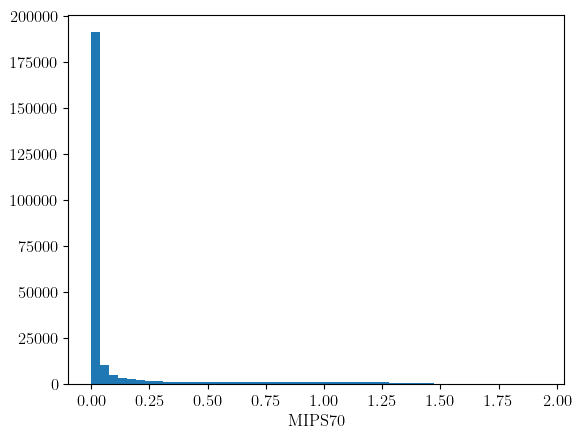

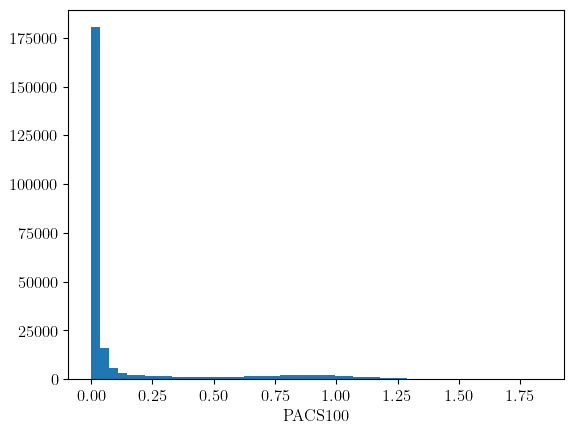

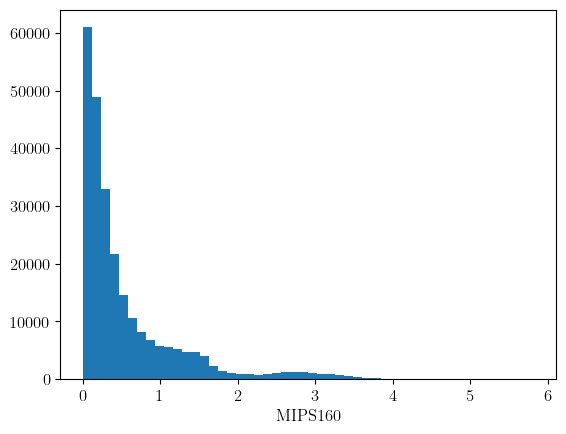

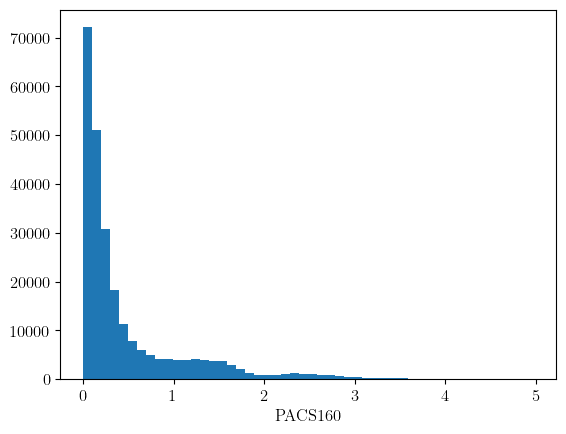

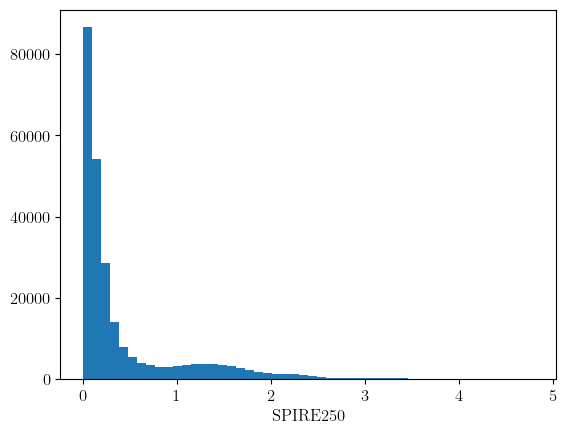

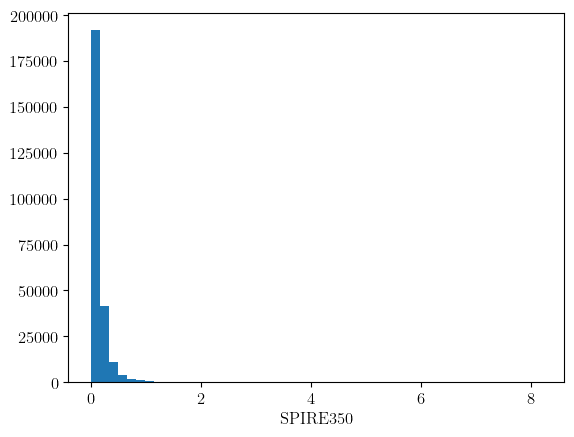

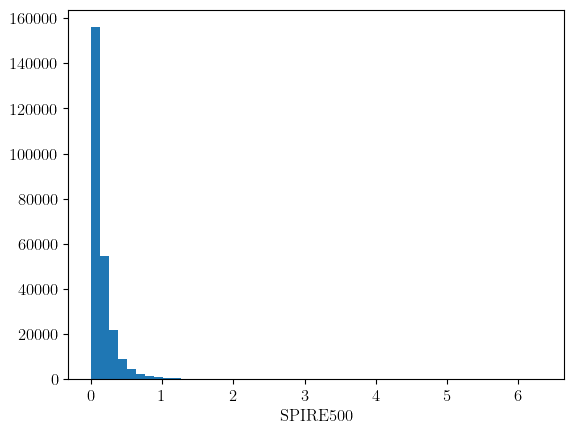

In [13]:
params = ['J', 'H', 'Ks', 'CH1', 'CH2', 'MIPS24', 'MIPS70', 'PACS100', 'MIPS160', 'PACS160', 'SPIRE250', 'SPIRE350', 'SPIRE500']
for i, param in enumerate(params):
    plt.hist(errs[i], bins=50)
    plt.xlabel(param)
    plt.show()

In [14]:
print(f'Order of results is {params}')
print(f'Fractional Error:\n\tmean = {np.mean(frac_errs, axis=1).round(4)} \n\tmedian = {np.median(frac_errs, axis=1).round(4)} \n\tstdev = {np.std(frac_errs, axis=1).round(4)}\n\n')
print(f'Error:\n\tmean = {np.mean(errs, axis=1).round(4)} \n\tmedian = {np.median(errs, axis=1).round(4)} \n\tstdev = {np.std(errs, axis=1).round(4)}\n\n')

print(f'Measured Uncertainties:\n\tmean = \t{np.mean(photo_yerr_test, axis=0).round(4)}\n\tmedian = {np.median(photo_yerr_test, axis=0).round(4)}\n\tstdev = {np.std(photo_yerr_test, axis=0).round(4)}\n\n')

print(f'Prediction RMSE = {np.sqrt(np.mean(errs**2, axis=1).round(4)).round(4)}')
print(f'Measured uncertainty/true value = {np.abs(np.mean(photo_yerr_test / photo_y_test, axis=0).round(4))}')

Order of results is ['J', 'H', 'Ks', 'CH1', 'CH2', 'MIPS24', 'MIPS70', 'PACS100', 'MIPS160', 'PACS160', 'SPIRE250', 'SPIRE350', 'SPIRE500']
Fractional Error:
	mean = [0.1791 0.4632 0.3704 0.021  0.1373 0.0552 0.0457 0.05   0.2003 0.2035
 0.2296 0.1804 0.17  ] 
	median = [0.0891 0.1795 0.1409 0.0043 0.0453 0.0019 0.0025 0.0033 0.1035 0.0874
 0.0845 0.1129 0.1013] 
	stdev = [0.2043 0.6092 0.4912 0.0526 0.1926 0.1348 0.1055 0.1049 0.2493 0.275
 0.3328 0.2365 0.2257]


Error:
	mean = [0.3722 0.5819 0.702  0.0629 0.412  0.1422 0.137  0.1448 0.5519 0.4813
 0.4335 0.128  0.1483] 
	median = [0.1851 0.2255 0.2669 0.013  0.1359 0.0048 0.0074 0.0097 0.2853 0.2068
 0.1595 0.0801 0.0884] 
	stdev = [0.4246 0.7654 0.9308 0.1578 0.5777 0.3472 0.3166 0.304  0.6867 0.6505
 0.6283 0.1678 0.1969]


Measured Uncertainties:
	mean = 	[5.51300000e-01 4.94000000e-01 5.36500000e-01 1.19900000e+00
 6.96900000e-01 5.71000000e-01 5.99700000e-01 6.61200000e-01
 5.55949470e+03 6.56800000e-01 4.22100000e-01 9.5386357

# Plot some examples

In [5]:
from SPLASH.pipeline import Splash_Pipeline

# Load pipeline object
pipeline = Splash_Pipeline(pipeline_version='weighted_full_band',   # the default version of the pipeline
                           pre_transformed=True,                   # whether the given data is pre-logged and nnormalized
                           within_4sigma=True,                      # whether we only want to classify objects with properties within 4-sigma of the training set
                           nan_thresh_ratio=1.0)                    # to keep this notebook concise, we are allowing the pipeline to imput any num of nans

In [6]:
inferred_seds, inferred_sederrs = pipeline.infer_sed(X_grizy=photo_X_test, X_grizy_err=photo_Xerr_test, n_resamples=10, return_normalized=False)

/Users/adamboesky/Research/ay98/Weird_Galaxies/SPLASH/pipeline.py:195: RuntimeWarning: overflow encountered in power
  X = 10 ** X
/Users/adamboesky/Research/ay98/Weird_Galaxies/SPLASH/pipeline.py:200: RuntimeWarning: overflow encountered in multiply
  X_err = np.abs(X_err[:, :n_bands] * (X[:, :n_bands] * np.log(10)))


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_29844/1623944202.py:14: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(2, 4, figsize=(17, 5))


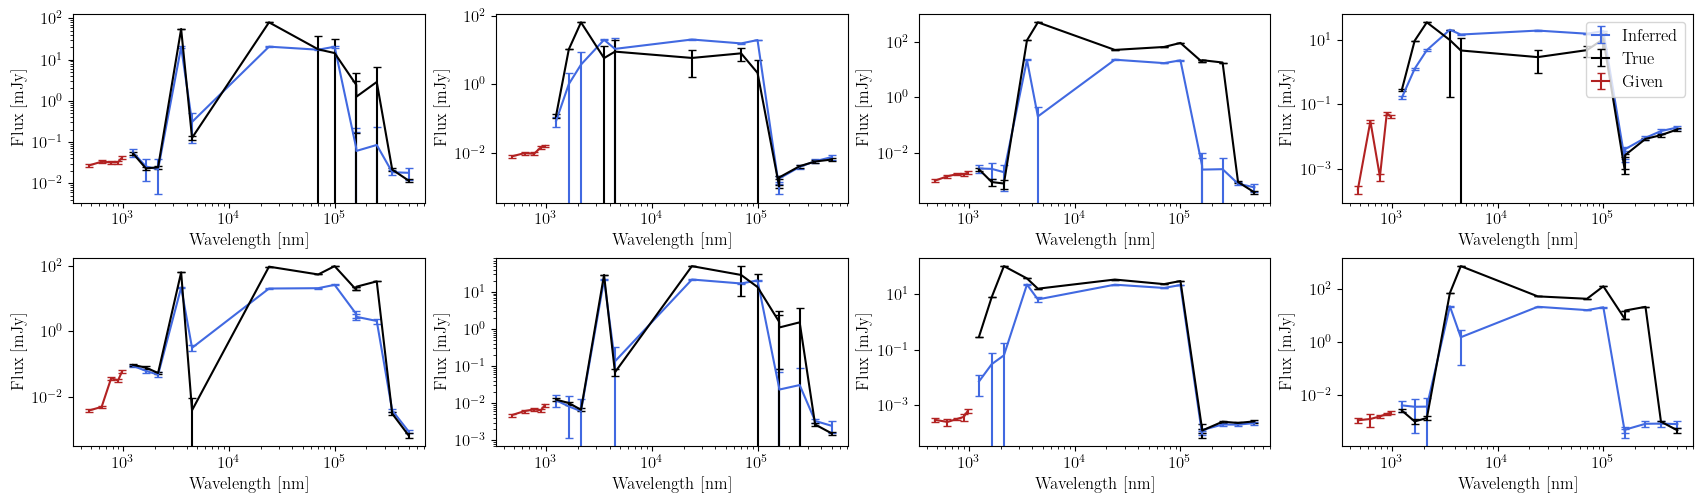

In [43]:
# Undo the upper limit thing
wavelengths_nm = [480, 630, 775, 900, 980, 1250, 1650, 2150, 3550, 4500, 24000, 70000, 100000, 160000, 160500, 250000, 350000, 500000]
upper_lim_mask = ~np.any(photo_y_test == 0.01, axis=1)
photo_y_test_plot = photo_y_test
for j in range(photo_y_test.shape[1]):
    mask = photo_y_test[:, j] == 0.01  # identify where the real value was set to the small value (upper limit case)
    photo_y_test_plot[:, j][mask] = photo_yerr_test[:, j][mask]  # restore the original values from the errors
    photo_yerr_test[:, j][mask] = 0  # restore the error to 0 for upper limit fluxes

real = (photo_y_test * photo_std[5:] + photo_mean[5:])
realerr = photo_yerr_test * np.abs(photo_std[5:])
real_grizy = (photo_X_test * photo_std[:5] + photo_mean[:5])
realerr_grizy = photo_Xerr_test * np.abs(photo_std[:5])
fig, axes = plt.subplots(2, 4, figsize=(17, 5))
for i, ax in enumerate(axes.flatten()):
    i = np.random.randint(inferred_seds.shape[0])
    pred = inferred_seds[i]
    errs = inferred_sederrs[i]
    ax.errorbar(x=wavelengths_nm[5:], y=pred[5:], yerr=errs[5:], color='royalblue', label='Inferred', capsize=3)
    ax.errorbar(x=wavelengths_nm[5:], y=10**real[i], yerr=np.log(10)*(10**real[i]) * realerr[i], color='k', label='True', capsize=3)
    ax.errorbar(x=wavelengths_nm[:5], y=10**real_grizy[i], yerr=np.log(10)*(10**real_grizy[i]) * realerr_grizy[i], color='firebrick', label='Given', capsize=3)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('Wavelength [nm]')
    ax.set_ylabel('Flux [mJy]')

axes[0, 3].legend(loc='upper right', handlelength=1)
plt.tight_layout(pad=0.5)
plt.show()